In [611]:
# Mudanças feitas nessa versão:
# - Análise feita por Houses;
# - Reorganização do código e adição de comentários;
# - Padronização de funções;
# - Criação de uma função para gerar os valores de EQMs;
# - Refatoração e melhoria do calculaDistancias, que agora é calculaEQM
# - Mudança no coeficiente C da regressão logística
# - Filtro de leituras deslocadas usando moda
# - !!! Refatorar "eqmPorFase"

In [612]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

In [613]:
# Bloco de Funções para leitura de dados

# O formato dos dados em "DT_EVENTO" é diferente daquele nos nomes das leituras
# Portanto, a função eventTimeConverter realiza essa conversão para auxiliar no tratamento dos dados
def eventTimeConverter(DataFrame, tamanhoBase):
    dtEvento = []
    for i in range(0, tamanhoBase):
        aux = DataFrame.iloc[i, 4].replace(' ', '_')
        aux = aux.replace('-', '')
        dtEvento.append(aux.replace(':', ''))
        
    return dtEvento

# Os dados das leituras estão em arquivos txt, logo, seu tipo é string
# Para poder realizar a manipulação dos mesmos, realiza-se a conversão por meio 
# da função stringToFloat
def stringToFloat(dataFrame, nome):
    dataFrame[nome] = pd.to_numeric(dataFrame[nome], downcast="float")

    
# A função getDados obtém os valores de corrente RMS nos txts já formatados
def getDados(Leitura, tipoDeDado):
    f = open(Leitura) # pode ser adicionado o .txt, mas ele ja esta presente nas colunas
    lines = f.readlines()
    i = 0
    while(i < len(lines)):
        i += 1
        if(lines[i] == "***End_of_Header***\n"):
            break
    
    Inicio = i + 2
    with open(Leitura) as f:
        linhas = f.readlines()[Inicio:]
    df = pd.DataFrame(linhas)
    df = df[0].str.split('\t', expand=True)
    stringToFloat(df, 2)
    
    if(tipoDeDado == 'tempo'):
        return np.array(df[0])
    if(tipoDeDado == 'corrente'):
        return np.array(df[1])
    if(tipoDeDado == 'correnteRMS'):
        return np.array(df[2])

# A função getLeituras obtém os valores de corrente RMS para cada leitura da house em análise
def getLeituras(maquinas, amostragem, maquinaAnalisada):
    for i in range(0, int(len(maquinas.index))):  
        try:
            leitura = getDados(maquinas['DS_LOCAL_INSTALACAO'].iloc[i] + '/' + maquinas['DS_ATIVO_SAP'].iloc[i] + '_'  + maquinas['DS_POS_CMD'].iloc[i]  + '_' + maquinas['DT_EVENTO'].iloc[i] + '.txt', 'correnteRMS')
        except FileNotFoundError:
            print("Leitura não encontrada: " + maquinas['DS_ATIVO_SAP'].iloc[i] + '_'  + maquinas['DS_POS_CMD'].iloc[i]  + '_' + maquinas['DT_EVENTO'].iloc[i] + '.txt')
        else:
            DF = pd.DataFrame(leitura, columns=[maquinas['DS_ATIVO_SAP'].iloc[i] + '_' + maquinas['DT_EVENTO'].iloc[i]])
            stringToFloat(DF, maquinas['DS_ATIVO_SAP'].iloc[i] + '_' + maquinas['DT_EVENTO'].iloc[i])
            DF = DF.transpose()
            maquinaAnalisada = pd.concat([maquinaAnalisada, DF,])
    maquinaAnalisada = maquinaAnalisada.transpose()
        
    return maquinaAnalisada

In [723]:
# Bloco de Funções para correção de dados

# Os inícios da Fase 1 não são padronizados, podendo começar em instantes diferentes
# Se o filtro não é utilizado, as curvas médias apresentam um comportamento bizarro, as médias não consideram deslocamento
def filtroLeituraDeslocada(leituras, dfPontosFase):
    leiturasFiltradas = []
    if(dfPontosFase.iloc[0,0] != None):
        moda = dfPontosFase.mode(axis=1)
        
        for i in range(0, len(dfPontosFase.columns)):
            if(dfPontosFase.iloc[0, i] > moda.iloc[0,0]*1.1 or dfPontosFase.iloc[0, i] < moda.iloc[0,0]/1.1): # filtra leituras cujo valor de fim da fase 0 é 40% maior que o valor mínimo
                leiturasFiltradas.append(dfPontosFase.columns[i])

        leituras = leituras.drop(leiturasFiltradas, axis=1)
    else:
        print('Não há leituras normais')
    return leituras

# Algumas leituras apresentam comportamento ruidoso, com correntes no intervalo [0,1]
# Para evitar que isso atrapalhe os cálculos e resultados, utiliza-se o filtro abaixo
# EXEMPLO DE LEITURA EM QUE ISSO ACONTECE: MCH004W21A_R_20190906_104250
def filtroLeiturasRuido(Maquinas):
    max = 0
    leiturasRuido = []
    for i in range(1, len(Maquinas.columns)):
        for j in range(0, len(Maquinas.index)):
            if(max <= Maquinas.iloc[j, i]):
                max = Maquinas.iloc[j, i]
        if(max < 1):
            leiturasRuido.append(Maquinas.columns[i])
        max = 0
    
    Maquinas = Maquinas.drop(leiturasRuido, axis=1)
    return Maquinas  

# Leituras realizadas no período entre Agosto e Outubro sofreram uma atenuação por um filtro
# aplicado pela Vale, para tratar os dados corretamente, é necessário corrigir os valores de 
# corrente dessas leituras
def corrigeCorrentes(Maquinas, fatorDeCorrecao):
    max = 0
    aux = 0
    for i in range(1, len(Maquinas.columns)):
        for j in range(0, len(Maquinas.index)):
            if(max <= Maquinas.iloc[j, i]):
                max = Maquinas.iloc[j, i]
        if(max < 12):
            Maquinas[Maquinas.columns[i]] = fatorDeCorrecao*Maquinas[Maquinas.columns[i]]
        max = 0
    
    return Maquinas

def plotaMarcado(corrente, fimDeFase, Leitura):
    corrente.plot(kind='line')
    plt.annotate('fim da fase 0', xy=(fimDeFase[0], corrente.iloc[fimDeFase[0]]), xytext=(1000, 0.5), arrowprops=dict(facecolor='black', shrink=0.05),)
    plt.annotate('fim da fase 1', xy=(fimDeFase[1], corrente.iloc[fimDeFase[1]]), xytext=(1100, 2.5), arrowprops=dict(facecolor='black', shrink=0.05),)
    #plt.annotate('fim da fase 2', xy=(fimDeFase[2], corrente.iloc[fimDeFase[2]]), xytext=(1300, 5), arrowprops=dict(facecolor='black', shrink=0.05),)
    plt.annotate('fim da fase 2', xy=(fimDeFase[2], corrente.iloc[fimDeFase[2]]), xytext=(4000, 7), arrowprops=dict(facecolor='black', shrink=0.05),)
    plt.annotate('fim da fase 3', xy=(fimDeFase[3], corrente.iloc[fimDeFase[3]]), xytext=(6000, 2), arrowprops=dict(facecolor='black', shrink=0.05),)
    plt.title(Leitura)
    plt.show()
    # trechos para teste:
    #leitura = 'MCH008W22A_20191130_222631'
    #plotaMarcado(maquinasPorEstado[0][leitura], PontosFase[0][leitura], leitura)


In [683]:
# Bloco de Funções para cálculos feitos com dados

def Derivada(valor, intervalo):
    derivada = np.diff(valor.values)/intervalo    #pode ser alterado pra utilizar a coluna do tempo ao inves de um intervalo 
    return derivada
    pd.set_option('display.max_rows', 300)

# Determina os fins de fase de uma leitura ou assinatura
def calculaFases(corrente, intervalo):
    deriv = np.array(Derivada(corrente, intervalo))
    corrente = np.array(corrente)
    fimFases = []
    fimFase0 = np.argmax(deriv[50:]>10) + 50
    fimFases.append(fimFase0)
    topo = 0
    topo = np.argmax(deriv[fimFase0:]<0)
    topo = topo + fimFase0
     
    metadeCorrente = np.argmax(corrente[topo:]<(corrente[topo]/2))  + topo
    fimFase1 = np.argmax(deriv[metadeCorrente + 1:]>-4)
    fimFase1 = fimFase1 + metadeCorrente + int(0.04545/intervalo)
    fimFases.append(fimFase1)
    #
    #descomentar quado se tratar de leituras novas
    #result = np.where(deriv[fimFase1 + int(0.15/intervalo):] == np.amin(deriv[fimFase1 + int(0.15/intervalo):fimFase1 + int(0.5/intervalo)]))
    #fimFase2 = result[0][0] + int(0.04/intervalo) + fimFase1 + int(0.15/intervalo)
    #fimFases.append(fimFase2)
    result = np.where(deriv == np.amax(deriv[fimFase1 + int(0.9/intervalo):fimFase1 + int(2/intervalo)]))
    fimFase3 = result[0][0] - int(0.04040/intervalo)
    fimFases.append(fimFase3)
    
    fimCorrente = np.argmax(corrente[fimFase3:]<(corrente[topo]/20)) + fimFase3
    fimFase4 = np.argmax(deriv[fimCorrente + 1:] > -1)
    fimFase4 = fimCorrente + fimFase4 - int(0.02020/intervalo)
    fimFases.append(fimFase4)
    return (fimFases)

# A função geraAssinaturaMedia plota um gráfico com as curvas mínima, média e máxima para leituras de uma house
# As curvas de máximo e mínimo podem deslocar mudando o valor do parametroStd 
def geraAssinaturaMedia(maquinaEmAnalise, parametroStd):
    assinaturaNormal = pd.DataFrame()
    dfex = maquinaEmAnalise
    assinaturaNormal = assinaturaNormal.assign(Tempo = lambda x: dfex['t (s)']) 
    dfex = dfex.drop("t (s)", axis=1)
    stdNormal = dfex.std(axis=1)
    mediaNormal = dfex.mean(axis=1)
    assinaturaNormal['Std'] = stdNormal
    assinaturaNormal['Média'] = mediaNormal
    assinaturaNormal['Curva mínima'] = mediaNormal - parametroStd*stdNormal
    assinaturaNormal['Curva máxima'] = mediaNormal + parametroStd*stdNormal
    dfex.shape
    for i in range(0, len(assinaturaNormal.index)):
        if(assinaturaNormal.iloc[i, 3] < 0):
            assinaturaNormal.iloc[i, 3] = 0
      
    return assinaturaNormal

def subtraiMedia(leituras, inicio, final, media, distanciaFases, i):
    dist = total = 0
    for j in range(inicio, final):
        dist += (leituras.iloc[j, i] - media)**2
        if(j == final-1):
            distanciaFases.append(dist/(final))
            total += dist
            dist = 0
    return total

def preparaEQM(blocoNormal, blocoLeitura):
    blocoNormal = blocoNormal.to_numpy()
    blocoLeitura = blocoLeitura.to_numpy()
    subtraction = np.subtract(blocoNormal, blocoLeitura)
    power = np.power(subtraction,2)
    dist = np.sum(power, axis=0)
    return dist

def eqmPorFase(normal, leituras, dfPontosFase, distanciaFases, pontosMedia, total, col, i): #!!!! Refatorar
    dist = 0
    for k in range(0,2):
        if(dfPontosFase.iloc[k+1, i-1] > dfPontosFase.iloc[k, i-1]):
            fragNormal = normal['Média'][int(pontosMedia['Fim da Fase ' + str(k)]): int(pontosMedia['Fim da Fase ' + str(k)]) + (int(dfPontosFase.iloc[k+1, i-1]) - int(dfPontosFase.iloc[k, i-1]))]
            fragLeitura = leituras[col][dfPontosFase.iloc[k, i-1]: dfPontosFase.iloc[k+1, i-1]]
            dist += preparaEQM(fragNormal, fragLeitura)
            distanciaFases.append(dist/(dfPontosFase.iloc[k+1, i-1] - dfPontosFase.iloc[k, i-1]))
            total += dist/(dfPontosFase.iloc[k+1, i-1] - dfPontosFase.iloc[k, i-1])
            dist = 0
        else:
            distanciaFases.append(0)
            total += 0
    
    if(int(pontosMedia['Fim da Fase 3']) > dfPontosFase.iloc[2, i-1]):
        fragNormal = normal['Média'][int(pontosMedia['Fim da Fase 2']): int(pontosMedia['Fim da Fase 2']) + (int(pontosMedia['Fim da Fase 3']) - int(dfPontosFase.iloc[2, i-1]))]
        fragLeitura = leituras[col][dfPontosFase.iloc[2, i-1]: int(pontosMedia['Fim da Fase 3'])]
        dist += preparaEQM(fragNormal, fragLeitura)
        distanciaFases.append(dist/(int(pontosMedia['Fim da Fase 3']) - dfPontosFase.iloc[2, i-1]))
        total += dist/(int(pontosMedia['Fim da Fase 3']) - dfPontosFase.iloc[2, i-1])
        dist = 0
    else:
        distanciaFases.append(0)
        total += 0

    return total

def calculaEQM (normal, leituras, dfPontosFase, pontosMedia, mediaInicio, mediaFim, amostragem):
    distanciasDF = pd.DataFrame(index =['EQM Fase 0', 'EQM Fase 1', 'EQM Fase 2', 'EQM Fase 3', 'EQM Fase 4', 'EQM Total'])
    distanciasDF = distanciasDF.transpose()
    distanciaFases = []
    dist = total = 0
    i = 1
    
    for col in leituras.columns:
        if(col != 't (s)'):
            total += subtraiMedia(leituras, 0, dfPontosFase.iloc[0, i-1], mediaInicio, distanciaFases, i)
            total += eqmPorFase(normal, leituras, dfPontosFase, distanciaFases, pontosMedia, total, col, i)
            total += subtraiMedia(leituras, dfPontosFase.iloc[3, i-1], len(leituras.index), mediaFim, distanciaFases, i)

            distanciaFases.append(total/amostragem)
            total = 0

            DF = pd.DataFrame(distanciaFases,index =['EQM Fase 0', 'EQM Fase 1', 'EQM Fase 2', 'EQM Fase 3', 'EQM Fase 4', 'EQM Total'], columns=[leituras.columns[i]])
            DF = DF.transpose()
            distanciaFases = []
            distanciasDF = pd.concat([distanciasDF, DF,])
            i += 1

    distanciasDF = distanciasDF.transpose()
    return distanciasDF

def geraTabelaEQM(mediaTotal, stdTotal):
    valores = []
    valores.append(mediaTotal.iloc[0])
    valores.append(mediaTotal.iloc[0] - stdTotal.iloc[0])
    valores.append(mediaTotal.iloc[0] + stdTotal.iloc[0])
    valoresDF = pd.DataFrame(valores, index=['Média','Mínima','Máxima'], columns=['EQM Fase 0'])
    valoresDF = valoresDF.transpose()
    valores = []
    for i in range(1, 6):
        valores.append(mediaTotal.iloc[i])
        valores.append(mediaTotal.iloc[i] - stdTotal.iloc[i])
        valores.append(mediaTotal.iloc[i] + stdTotal.iloc[i])
        if(i < 5):
            valoresAux = pd.DataFrame(valores, index=['Média','Mínima','Máxima'], columns=['EQM Fase ' + str(i)])
        else:
            valoresAux = pd.DataFrame(valores, index=['Média','Mínima','Máxima'], columns=['EQM Total'])
        valores = []
        valoresAux = valoresAux.transpose()
        valoresDF = pd.concat([valoresDF, valoresAux, ])
    return valoresDF

In [907]:
%%time
pd.options.display.max_rows = 8200
pd.options.display.max_columns = 4000

baseDF = pd.read_csv('BASE_TREINAMENTO.csv', sep=",")
dt = eventTimeConverter(baseDF, tamanhoBase) # Corrige o formato das datas para igualar àqueles dos txts
dtEvento = pd.DataFrame(dt, columns=['DT_EVENTO'])
baseDF = baseDF.assign(DT_EVENTO=dtEvento['DT_EVENTO'])

amostragem = 8182 # Número de pontos em cada amostra
tamanhoBase = len(baseDF) # Número de leituras classificadas disponíveis na base

#fabricante = 'KY NS-AM'
fabricante = 'KY SLNS-1A'

house = 'H004' # House em análise
#house = 'H006' # caso o fabricante seja KY NS-AM

maquinasPorFabricante = baseDF.loc[(baseDF["DS_FABRICANTE"] == fabricante)]
maquinas = maquinasPorFabricante.loc[(baseDF["DS_LOCAL_INSTALACAO"] == house)]
#maquinas.to_csv(house + '.csv')

dt = getDados('H004/MCH004W21A_N_20190817_190721.txt', 'tempo') # Eixo x (pode ser qualquer leitura)
maquinaAnalisada = pd.DataFrame(dt, columns=['t (s)']) 
stringToFloat(maquinaAnalisada, 't (s)')
maquinaAnalisada = maquinaAnalisada.transpose()

CPU times: user 140 ms, sys: 12.3 ms, total: 153 ms
Wall time: 156 ms


In [908]:
%%time
# Separação por estado da máquina
maquinasSemDefeito = maquinas.loc[maquinas["DS_ESTADO"] == 'Sem Defeito']
maquinasDefeito = maquinas.loc[maquinas["DS_ESTADO"] == 'Defeito']
maquinasFalha = maquinas.loc[maquinas["DS_ESTADO"] == 'Falha']

# Obtenção dos valores de corrente para cada leitura em cada classificação
maquinasPorEstado = [] # Sem defeito: 0; Defeito: 1; Falha: 2
maquinasPorEstado.append(getLeituras(maquinasSemDefeito, amostragem, maquinaAnalisada))
maquinasPorEstado.append(getLeituras(maquinasDefeito, amostragem, maquinaAnalisada))
maquinasPorEstado.append(getLeituras(maquinasFalha, amostragem, maquinaAnalisada))

Leitura não encontrada: MCH004W22A_N_20200428_051834.txt
CPU times: user 26.3 s, sys: 2.7 s, total: 29 s
Wall time: 30.4 s


In [909]:
%%time
# Filtra leituras ruidosas
for i in range(0,3):  
    maquinasPorEstado[i] = filtroLeiturasRuido(maquinasPorEstado[i])
    
# Corrige leituras atenuadas entre agosto e outubro (se houver)
fatorDeCorrecao = 1.55 # O fator de correçao ainda é um valor estimado, não foi um dado fornecido pela Vale
for i in range(0,3):  
    maquinasPorEstado[i] = corrigeCorrentes(maquinasPorEstado[i], fatorDeCorrecao)

CPU times: user 1min 30s, sys: 41.2 ms, total: 1min 30s
Wall time: 1min 30s


In [910]:
%%time
PontosFase = []
dfPontosFase = pd.DataFrame(index =['Fim da Fase 0', 'Fim da Fase 1', 'Fim da Fase 2', 'Fim da Fase 3'])

for rotulo in range(0, 3):
    for col in maquinasPorEstado[rotulo]:
        if (col != 't (s)'):
            pontos = calculaFases(maquinasPorEstado[rotulo][col], 0.00101)
            dfPontosFase[col] = pontos
    PontosFase.append(dfPontosFase)
    dfPontosFase = pd.DataFrame(index =['Fim da Fase 0', 'Fim da Fase 1', 'Fim da Fase 2', 'Fim da Fase 3'])

CPU times: user 491 ms, sys: 2.28 ms, total: 494 ms
Wall time: 492 ms


CPU times: user 158 ms, sys: 1.79 ms, total: 160 ms
Wall time: 159 ms


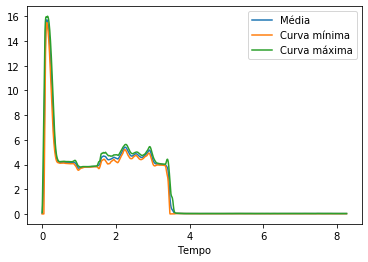

In [911]:
%%time
# Média normal com filtro de leituras deslocadas
normaisDeslocamentoFiltrado = filtroLeituraDeslocada(maquinasPorEstado[0], PontosFase[0])
parametroStd = 1
normal = geraAssinaturaMedia(normaisDeslocamentoFiltrado, parametroStd)

ax = plt.gca()
normal.plot(kind='line',x='Tempo',y='Média',ax=ax)
normal.plot(kind='line',x='Tempo',y='Curva mínima',ax=ax)
normal.plot(kind='line',x='Tempo',y='Curva máxima',ax=ax)

In [912]:
%%time
dfPontosFase = pd.DataFrame(index =['Fim da Fase 0', 'Fim da Fase 1', 'Fim da Fase 2', 'Fim da Fase 3'])

for col in normaisDeslocamentoFiltrado:
    if (col != 't (s)'):
        pontos = calculaFases(normaisDeslocamentoFiltrado[col], 0.00101)
        dfPontosFase[col] = pontos

# Calcula os pontos de troca de fase da assinatura
pontosMediaFilt = dfPontosFase.mean(axis=1)
print (pontosMediaFilt)

# Esse bloco calcula uma media dos valores normais para a fase inicial para ser comparada com as leituras em
# análise, a escolha desse metodo serve para contornar os casos em que o início da fase 1 esta deslocado.
mediaInicio = mediaFim = 0

for c in range(0, int(pontosMediaFilt.iloc[0])):
    mediaInicio += normal.iloc[c, 2]
mediaInicio = mediaInicio/int(pontosMediaFilt.iloc[0])
    
# Esse bloco e análogo ao primeiro, fazendo o mesmo processo mas para a fase final
for d in range(int(pontosMediaFilt.iloc[3]), amostragem):
    mediaFim += normal.iloc[d, 2]
mediaFim = mediaFim/int(pontosMediaFilt.iloc[3])

Fim da Fase 0      50.000000
Fim da Fase 1     457.178571
Fim da Fase 2    1531.571429
Fim da Fase 3    3481.607143
dtype: float64
CPU times: user 60.4 ms, sys: 1.86 ms, total: 62.2 ms
Wall time: 60.8 ms


In [913]:
%%time
# Cálculo dos erros quadráticos médios
eqmNormal = calculaEQM(normal, maquinasPorEstado[0], PontosFase[0], pontosMediaFilt, mediaInicio, mediaFim, amostragem)
eqmNormal = eqmNormal.transpose()
eqmNormal['rotulo'] = 0
eqmDefeito = calculaEQM(normal, maquinasPorEstado[1], PontosFase[1], pontosMediaFilt, mediaInicio, mediaFim, amostragem)
eqmDefeito = eqmDefeito.transpose()
eqmDefeito['rotulo'] = 1
eqmFalha = calculaEQM(normal, maquinasPorEstado[2], PontosFase[2], pontosMediaFilt, mediaInicio, mediaFim, amostragem)

CPU times: user 47.4 s, sys: 55.6 ms, total: 47.4 s
Wall time: 47.5 s


In [914]:
# junta os dataframes de normal e defeito
principal = pd.concat([eqmNormal, eqmDefeito])
principal

,EQM Fase 0,EQM Fase 1,EQM Fase 2,EQM Fase 3,EQM Fase 4,EQM Total,rotulo
MCH004W21A_20190820_041558,66.864108,6.444788,0.008108,0.174468,0.000162,0.818182,0
MCH004W21A_20190820_070907,64.694411,6.401585,0.010958,0.242729,0.000137,0.791643,0
MCH004W21A_20190821_030949,61.169333,7.912699,0.006140,0.033529,0.000152,0.748733,0
MCH004W21A_20190825_221621,2.383083,0.083315,0.004826,0.062547,0.000143,0.029287,0
MCH004W21A_20190825_223820,2.242377,0.115879,0.007064,0.029540,0.000128,0.027553,0
MCH004W21B_20190824_051910,2.750588,4.316721,0.071568,0.632401,0.000131,0.057222,0
MCH004W21B_20190824_223933,2.777361,4.824434,0.080412,1.374206,0.000165,0.057959,0
MCH004W21B_20190821_030949,2.758484,4.109740,0.144340,0.519315,0.000148,0.059394,0
MCH004W22A_20190824_223933,2.750235,3.689107,0.475370,1.152548,0.000152,0.102986,0
MCH004W22A_20190825_235713,2.761048,3.700083,0.473402,0.872848,0.000125,0.091180,0


In [915]:
# divide em dataframe de treino e teste
from sklearn.model_selection import train_test_split
train, test = train_test_split(principal, random_state=0)

In [916]:
# configura as features a ser analisadas, e treina o modelo
from sklearn.linear_model import LogisticRegression
feature_cols = ['EQM Fase 0', 'EQM Fase 1', 'EQM Fase 2', 'EQM Fase 3', 'EQM Fase 4']
X_treino = train.loc[:, feature_cols]
y_treino = train.rotulo
X_teste = test.loc[:, feature_cols]
y_teste = test.rotulo
modelo = LogisticRegression(C = 15)
modelo.fit(X_treino, y_treino)

LogisticRegression(C=15, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [917]:
# testa a acuracia na base de treino e teste
print('Accuracy of Logistic regression classifier on training set: {:.2f}'
     .format(modelo.score(X_treino, y_treino)))
print('Accuracy of Logistic regression classifier on test set: {:.2f}'
     .format(modelo.score(X_teste, y_teste)))

Accuracy of Logistic regression classifier on training set: 0.80
Accuracy of Logistic regression classifier on test set: 0.83


In [918]:
X_treino.shape

(670, 5)

In [895]:
predictions = modelo.predict_proba(X_teste)
predictions

array([[3.00313371e-02, 9.69968663e-01],
       [6.08467918e-01, 3.91532082e-01],
       [5.24350579e-01, 4.75649421e-01],
       [2.79345580e-01, 7.20654420e-01],
       [1.49455401e-02, 9.85054460e-01],
       [6.47267236e-01, 3.52732764e-01],
       [4.74476282e-01, 5.25523718e-01],
       [0.00000000e+00, 1.00000000e+00],
       [2.42425291e-01, 7.57574709e-01],
       [1.19542868e-01, 8.80457132e-01],
       [2.34618715e-01, 7.65381285e-01],
       [3.56337522e-01, 6.43662478e-01],
       [8.78681189e-02, 9.12131881e-01],
       [1.32554463e-01, 8.67445537e-01],
       [3.11632358e-01, 6.88367642e-01],
       [3.65766597e-01, 6.34233403e-01],
       [4.96521598e-01, 5.03478402e-01],
       [5.30579383e-01, 4.69420617e-01],
       [3.12670083e-01, 6.87329917e-01],
       [3.69447124e-01, 6.30552876e-01],
       [8.39279044e-05, 9.99916072e-01],
       [6.54855872e-02, 9.34514413e-01],
       [2.23752208e-01, 7.76247792e-01],
       [1.36662475e-01, 8.63337525e-01],
       [7.032547

In [896]:
y_teste

MCH004W21B_20190829_211525    1
MCH004W22B_20200330_003949    0
MCH004W21A_20190828_035641    1
MCH004W21A_20190829_100609    0
MCH004W21B_20200403_130336    1
MCH004W21A_20200129_161230    1
MCH004W21A_20190828_000428    1
MCH004W22A_20190820_045829    1
MCH004W21A_20190831_105650    1
MCH004W21B_20190826_144516    1
MCH004W21A_20190827_125535    1
MCH004W22B_20190824_235319    1
MCH004W21B_20190825_142334    1
MCH004W21B_20191202_171441    1
MCH004W21A_20190830_051523    1
MCH004W22B_20190823_195740    0
MCH004W22B_20190909_152549    0
MCH004W21A_20200414_105528    1
MCH004W21A_20190921_141634    1
MCH004W21B_20190826_123601    1
MCH004W21B_20190819_164236    1
MCH004W22A_20190830_095956    1
MCH004W22A_20200330_003518    0
MCH004W22B_20200406_191347    1
MCH004W22B_20200124_020108    0
MCH004W21A_20191017_200819    1
MCH004W22A_20190903_080016    1
MCH004W22B_20200321_000116    0
MCH004W21A_20191004_232949    1
MCH004W21A_20190829_114609    1
MCH004W21A_20190819_160400    1
MCH004W2

In [897]:
modelo.get_params()

{'C': 15,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [344]:
print (modelo.coef_)

[[-0.5661035   0.04153621  0.28930331 -0.09533533  0.34982894]]


In [ ]:
# Plotagem de leituras individuais para análise
house = 'H007' #MCH007W22B_20190828_010533
tipoDeMaquina = 'MCH007W22B'
configuracao = 'N'
leitura = '20190828_010533'

Leitura = house + '/' + tipoDeMaquina + '_' + configuracao + '_' + leitura + '.txt'
dt = getDados('H006/MCH006W22B_N_20191014_132901.txt', 'tempo')
selecionadas = pd.DataFrame()
selecionadas['t (s)'] = dt
stringToFloat(selecionadas, 't (s)')
selecionadas = selecionadas.transpose()
leituras = getDados(Leitura, 'correnteRMS')
DF = pd.DataFrame(leituras, columns=[Leitura])
stringToFloat(DF, Leitura)

max = 0
for j in range(0, len(DF.index)):
    if(max <= DF.iloc[j, 0]):
        max = DF.iloc[j, 0]
    
if(max < 12):
    for j in range(0, len(DF.index)):
        aux = DF.iloc[j, 0]
        DF.iloc[j, 0] = aux*fatorDeCorrecao

DF = DF.transpose()
selecionadas = pd.concat([selecionadas, DF,])
selecionadas = selecionadas.transpose()

ax = plt.gca()
selecionadas.plot(kind='line',x='t (s)',y=Leitura,ax=ax)